In [3]:
## Installations

!pip install uv
!uv pip install --system colpali_engine>=0.3.1 datasets huggingface_hub[hf_transfer] qdrant-client transformers>=4.45.0 stamina rich

In [7]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from typing import cast
from datasets import load_dataset
from qdrant_client import QdrantClient
from qdrant_client.http import models
from colpali_engine.models import ColPali, ColPaliProcessor

In [8]:
## To enable faster downloads

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [9]:
## Setting up the ColPali model

model_name = "vidore/colpali-v1.2"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
## Bring the dataset for state of ai 2024 (https://huggingface.co/datasets/atitaarora/state-of-ai-2024) report as images

dataset = load_dataset("atitaarora/state-of-ai-2024", split="train")

In [ ]:
## dataset info
dataset

In [ ]:
## random selection of the page from the dataset to see what it looks like
dataset[39]["image"]

In [13]:
## Setting Qdrant in memory
qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage


In [14]:
## Collection name to use throughout the notebook
collection_name = "colpali-state-of-ai"

In [15]:
## General Collection level operations

## Get information about existing collections 
#qdrant_client.get_collections()

## Get information about specific collection
#collection_info = qdrant_client.get_collection(collection_name)
#print(collection_info)

## Deleting collection, if need be
#qdrant_client.delete_collection(collection_name)

In [ ]:
## Setting up the ColPali model
## From https://huggingface.co/vidore/colpali
## ColPali: Visual Retriever based on PaliGemma-3B with ColBERT strategy

from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "vidore/colpali-v1.2"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

In [17]:

sample_image = dataset[0]["image"]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

In [ ]:
sample_embedding

In [19]:
sample_embedding.shape

torch.Size([1, 1030, 128])

In [20]:
## determining the length of the vectors for collection configuration.
vector_size = sample_embedding.shape[2]
vector_size

128

In [21]:
## Create a collection in Qdrant with a multivector configuration with 
## Quantization(process to convert the vectors to 8-bit integers, reducing the memory footprint and speeding up the search)
## Also added always_ram = True to keep the vectors in RAM which will increase performance at the cost of memory usage.

qdrant_client.create_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(indexing_threshold=0),
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                quantile=0.99,
                always_ram=True,
            ),
        ),
    ),
)

True

In [22]:
## Helper fucntion to uploading the vectors to Qdrant
## Using Stamina - https://github.com/hynek/stamina to enable production-grade retires in Python
import stamina


@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [23]:
## Vector creation and ingesting them into Qdrant

batch_size = 4  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )
        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        # clown level error handling here 🤡
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 100%|█████████████████████████████████████████████████████████| 212/212 [19:50<00:00,  5.61s/it]

Indexing complete!


In [24]:
## For efficiency - https://qdrant.tech/documentation/tutorials/bulk-upload/#disable-indexing-during-upload

qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

False

In [25]:
## Checking the indexed vectors
qdrant_client.scroll(collection_name=collection_name, limit=10)

([Record(id=0, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=5, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=6, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=7, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=8, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=9, payload={'source': 'internet archive'}, vector=None, shard

### Search 101 using Multivector in Qdrant

In [26]:
## Query embedding processing
query_text = "what is the process of shrinking the memory requirements of LLM by reducing the precision of their parameters called?"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 1.6406e-01, -2.0020e-02,  9.8145e-02,  ..., -3.1738e-02,
          -7.7148e-02, -2.5391e-02],
         [-1.1279e-01, -1.2891e-01,  5.1514e-02,  ..., -1.2573e-02,
          -1.1133e-01,  1.2402e-01],
         [-1.6992e-01, -1.9043e-01,  1.1426e-01,  ..., -8.7280e-03,
          -7.7148e-02,  9.2773e-02],
         ...,
         [ 3.5048e-05, -1.5723e-01,  8.6426e-02,  ..., -4.8584e-02,
           4.6875e-02, -5.7129e-02],
         [-2.4292e-02, -1.4648e-01,  2.0508e-02,  ..., -1.2451e-01,
           7.1289e-02,  3.1494e-02],
         [-9.4238e-02, -6.5918e-02,  6.7383e-02,  ..., -1.7188e-01,
           3.9551e-02,  7.8613e-02]]], device='mps:0', dtype=torch.bfloat16)

In [27]:
query_embedding[0].shape

torch.Size([35, 128])

In [28]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [29]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=2, timeout=60
)

search_result.points

[ScoredPoint(id=129, version=0, score=24.091031993583332, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=143, version=0, score=19.29314039185301, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None)]

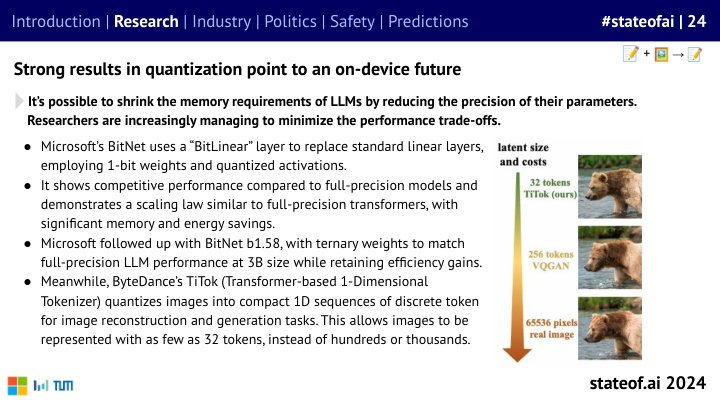

In [30]:
## Inspecting the image returned corresponding to the vector
idx = search_result.points[0].id
dataset[idx]["image"]

### Modularise the `search-image-by-text` and `search-by-text-and-return-images` process for smoother transition into building RAG

In [32]:
def search_images_by_text(query_text, top_k=2):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, limit=top_k
    )

    return search_result

def search_by_text_and_return_images(query_text, top_k=2):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return dataset.select(row_ids)

In [33]:
# Example vector retrieval request
query_text = "What is state of RAG evaluation from the given report?"
results = search_images_by_text(query_text)

for result in results.points:
    print(result)

id=140 version=0 score=16.552075874373255 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=138 version=0 score=14.311785598000021 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None


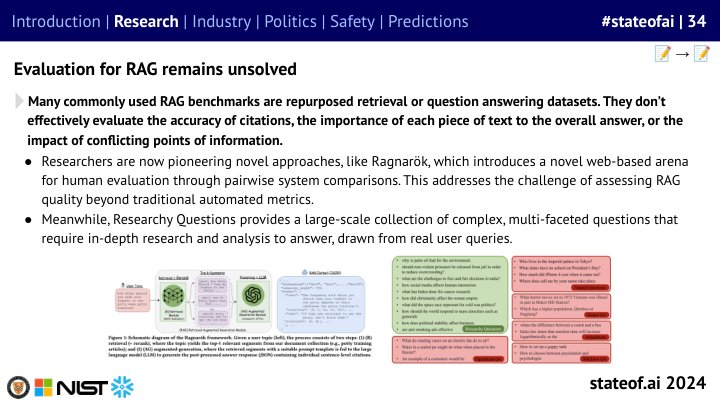

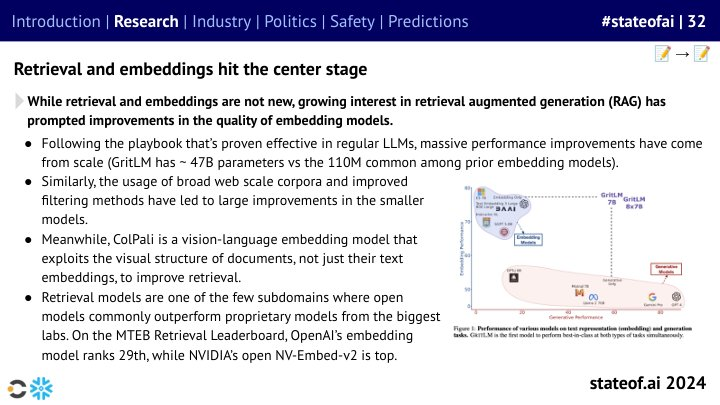

In [34]:
# Example image retrieval request
results_ds = search_by_text_and_return_images(query_text)

for row in results_ds:
    # display image
    display(row["image"])

### Lets build Multimodal RAG using Colpali using OpenAI

In [35]:
#!pip install openai

In [36]:
# OpenAI API Key
OPENAI_API_KEY= os.getenv("OPENAI_API_KEY")

#### Bringing it all together 

In [37]:
from openai import OpenAI
import base64
from io import BytesIO

client = OpenAI(api_key=OPENAI_API_KEY)


# Function to encode an image to base64
def encode_image(image_obj):
    buffered = BytesIO()
    image_obj.save(buffered, format="JPEG")  # Adjust format as needed
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# process the retrieved images for response generation
def process_images_for_query_response(query_text):

    # Assuming this method returns a list of dictionaries with an 'image' key containing PIL image objects.
    results_ds = search_by_text_and_return_images(query_text)
    
    # Encode all images from the result set
    encoded_images = [
        f"data:image/jpeg;base64,{encode_image(result['image'])}" for result in results_ds
    ]
    
    # Create message content with text and images
    content = [{"type": "text", "text": query_text}] + [
        {"type": "image_url", "image_url": {"url": image_url}} for image_url in encoded_images
    ]
    
    # Send the request to the API
    response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
        {
          "role": "user",
          "content": content,
        }
      ],
      max_tokens=300,
    )
    
    print(response.choices[0].message.content)


### Question 1 - What is state of RAG evaluation from the given report?

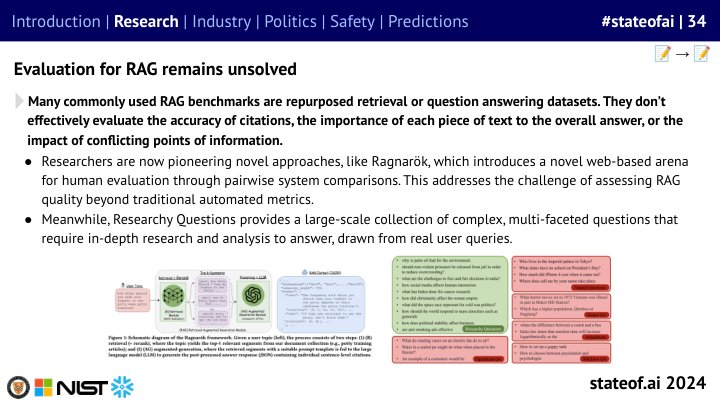

In [46]:
## Query to test retrieval
query_text = "What is state of RAG evaluation from the given report?"
search_by_text_and_return_images(query_text,top_k=2)[0]['image']

In [38]:
## Let's test the response generation
process_images_for_query_response(query_text)

The evaluation of Retrieval-Augmented Generation (RAG) remains an unresolved challenge, according to the report. Key points from the evaluation state include:

1. **Ineffective Benchmarks**: Many traditional benchmarks used for RAG are taken from existing retrieval or question-answering datasets, failing to adequately assess citation accuracy and the relevance of each source contributing to the overall answer. They also do not effectively address conflicting information from multiple sources.

2. **Novel Approaches**: Researchers are exploring new methods, such as the Ragnarök system, which offers a web-based platform for pairwise comparison of responses. This aims to assess RAG quality more comprehensively than conventional automated metrics can.

3. **Research Complexity**: The report emphasizes the need for in-depth research questions that reflect real user queries. This complexity necessitates a more nuanced analysis to evaluate RAG capabilities effectively.

Overall, the landscape

### Question 2 -  What were the root causes of interupions during Llama 3 405B pretraining?
Note so obvious question as it involves Summarisation of the pie chart

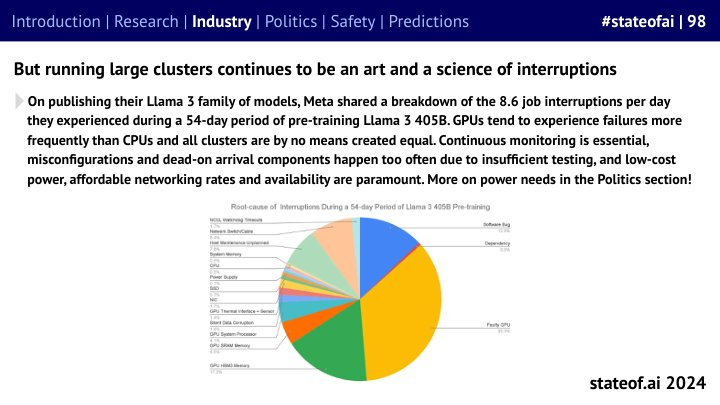

In [51]:
query_text_3 = "what were the root causes of interupions during Llama 3 405B pretraining?" 
search_by_text_and_return_images(query_text_3,top_k=2)[0]['image']
#process_images_for_query_response(query_text_3)

In [ ]:
process_images_for_query_response(query_text_3)

### Conclusions

I have been pleasantly surprised as well as amazed at the capabilities of Colpali. Having worked with many applications involving complex
PDF structures parsing and synthesising the images as well as text information at the same time for response generation , I am very positive for the possibilities this approach may bring to the upcoming RAG applications.

Excited !!!